In [ ]:
%%capture
!pip install --upgrade matplotlib #relevant as colab's default version doesnt support bar_label attribute
# Restart the kernel automatically with upgraded matplotlib
import os
os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/STTM

/content/gdrive/MyDrive/STTM


In [ ]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve,roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import pickle

inspect which GPU is allocated for the task

In [ ]:
!nvidia-smi

Mon Jun 13 21:42:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Building a corpus of concatenated conversations between users
each row in data corpus stands for a complete chat between users

In [ ]:
import string as string_lib
regular_punct = list(string_lib.punctuation)
extra_punct = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

all_punct = list(set(regular_punct + extra_punct))
def spacing_punctuation(text):
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text
def remove_url(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)    
    return text
def preprocess_text(text,mapping = contraction_mapping):
    text=remove_url(text)
    text=clean_contractions(text, mapping)
    text=spacing_punctuation(text)
    return text


In [ ]:
def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                #preprocess:
                # text = preprocess_text(text)
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels

In [ ]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"

training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax = (pd.Series(train_labels).value_counts()/len(train_labels)*100).round(2).plot(kind='bar',title='Train labels distribution',ax= ax1)
ax.bar_label(ax1.containers[0])
ax = (pd.Series(test_labels).value_counts()/len(test_labels)*100).round(2).plot(kind='bar',title='Test labels distribution',ax=ax2)
ax.bar_label(ax2.containers[0])
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)
plt.show()

# TF-IDF on data
We will now represent all conversations using BOW with TF-IDF weighting scheme.

In [ ]:
%%capture
!pip -q install stop-words

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from stop_words import get_stop_words #The words we want to ignore

stop_words_eng = get_stop_words('en') #Spanish StopWords
stops = list(set(stop_words_eng + list(STOPWORDS)))
stops.extend(['\r\n','\r','\n','ye','apos'])

In [ ]:
# vectorizer = TfidfVectorizer(stop_words=stops,ngram_range=(1,3))
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

# Create PJ dataset as test set on trained corpus

In [ ]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')


In [ ]:
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    string = " "
    for text in df.BODY.tolist():
        if text is not None:
            #preprocess:
            #preprocess:
            # text = preprocess_text(text)
            string = string + "\r\n" + text 
    corpus_pj.append(string)
    labels_pj.append(1)

In [ ]:
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)#[:,best_feat]
y_test_pj = np.array(labels_pj)

#LightGBM model classification

In [ ]:
import lightgbm as lgb
modelgbm = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
modelgbm.fit(X_train, y_train)
pred_y = modelgbm.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))
# try on PJ dataset:
pred_y = modelgbm.predict(X_test_pj)
print(metrics.accuracy_score(y_test_pj, pred_y))
np.unique(pred_y,return_counts=True)

0.9857794853282451
0.9821428571428571


(array([0, 1]), array([ 1, 55]))

# XGBoost model classification

In [ ]:
np.random.seed(12)
model_b = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False, learning_rate = 0.3, n_estimators=1000, max_depth=4,
 min_child_weight=0, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1,seed=27, reg_alpha= 1e-07)
model_b.fit(X_train, y_train)
pred_y = model_b.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = model_b.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.52702284565005
Accuracy on PJ test dataset:  96.42857142857143


(array([0, 1]), array([ 2, 54]))

In [ ]:
np.random.seed(12)
model_b = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)
model_b.fit(X_train, y_train)
pred_y = model_b.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = model_b.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

try with best features to achieve higher accuracy on test sets

In [ ]:
best_feat = pd.Series(model_b.feature_importances_).sort_values(ascending=False).nlargest(155).index.tolist()
model_best_feat = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)
model_best_feat.fit(X_train[:,best_feat], y_train)
pred_y = model_best_feat.predict(X_test[:,best_feat])
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj[:,best_feat]
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_best_feat.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.49608065597441
Accuracy on PJ test dataset:  96.42857142857143


(array([0, 1]), array([ 2, 54]))

# Applying SVM 

Linear support

In [ ]:
#SVM
model_linear = LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)
model_linear.fit(X_train, y_train)
pred_y = model_linear.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_linear.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.51026249290908
Accuracy on PJ test dataset:  98.21428571428571


(array([0, 1]), array([ 1, 55]))

C-Support Vector

In [ ]:
# linear kernel SVM 
model_svc = svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)
model_svc.fit(X_train, y_train)
pred_y = model_svc.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_svc.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.56054355113197
Accuracy on PJ test dataset:  96.42857142857143


(array([0, 1]), array([ 2, 54]))

# SVM improvemets

In [ ]:
#eclf = VotingClassifier(estimators=[('linear', xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)), ('svc', model_svc),])#, voting='soft', weights=[1, 1]) with soft the test acc is 98.589 and pj is 98.214
eclf = VotingClassifier(estimators=[('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)), ('svc', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True))],voting='soft', weights=[1, 1])#, voting='soft', weights=[1, 1]) with soft the test acc is 98.589 and pj is 98.214
eclf.fit(X_train, y_train)
pred_y =eclf.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# X_test_pj = vectorizer.transform(corpus_pj)
# X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
# X_test_pj =X_test_pj
# y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = eclf.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
    ('sv,', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)),
     ('svtwo', LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)),
     ('xgb',xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)),
      ('linear', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42))]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
pred_y =clf.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
pred_y = clf.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['Victim', 'Predator']
print(classification_report(y_test, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Victim       0.99      1.00      0.99    151391
    Predator       0.76      0.55      0.64      3737

    accuracy                           0.99    155128
   macro avg       0.88      0.77      0.82    155128
weighted avg       0.98      0.99      0.98    155128



# Applying CNN

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Conv1D, Activation, Input, Embedding, Multiply,SpatialDropout1D,Dropout,MaxPooling1D,Flatten
from keras.models import Model

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus).astype('float32')
X_test = vectorizer.transform(test_corpus).astype('float32')
tf_len = len(vectorizer.vocabulary_)
X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)
##pj -data 
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)#[:,best_feat]
y_test_pj = np.array(labels_pj)

In [ ]:
def reshape_to_cnn(mat):
  return mat.toarray().reshape(mat.shape[0], mat.shape[1],1) 

In [ ]:
def csr_to_sparsetensor(X):
    t = X.nonzero()
    a2 = []
    for i in range(len(t[0])):
        a2.append([t[0][i], t[1][i]])
    a2 = sorted(a2,key=lambda x: (x[0],x[1]))
    return tf.compat.v1.SparseTensorValue(a2, X.data, list(X.shape))


In [ ]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [ ]:
input = Input(batch_shape=(None, tf_len, 1))#Input(shape=(1,tf_len))  
drop20 = SpatialDropout1D(0.3)(input)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(drop20)
drop21 = Dropout(0.5)(conv2)
conv22 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop21)
drop22 = Dropout(0.5)(conv22)
pool2 = MaxPooling1D(pool_size=2)(drop22)
flat2 = Flatten()(pool2)
out = Dense(1, activation='sigmoid')(flat2)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [ ]:
model.fit(reshape_to_cnn(X_train), y_train,
                batch_size=256, shuffle="batch",
                epochs=3)

In [ ]:
pred_y = model.predict(reshape_to_cnn(X_test_pj))

In [ ]:
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj, np.round(pred_y).flatten())*100)

Accuracy on PJ test dataset:  0.0


# Applying DeepNN

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import random as python_random
import tensorflow as tf

In [ ]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [ ]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer()

# PAN12 data
X_train = vectorizer.fit_transform(train_corpus).astype('float16')
X_test = vectorizer.transform(test_corpus).astype('float16')
y_train = np.array(train_labels)
y_test = np.array(test_labels)
##pj -data 
X_test_pj = vectorizer.transform(corpus_pj).astype('float16')
y_test_pj = np.array(labels_pj)

In [ ]:
# Model Training 
print ("Create model ... ")
def build_model(shape):
    K.clear_session()
    np.random.seed(12)
    python_random.seed(12)
    tf.random.set_seed(12)
    model = Sequential()
    model.add(Dense(256, input_dim=shape, activation='relu'))
    # model.add(Dense(256, input_dim=121394, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

print("Compile model ...")
modeldnn = build_model(X_train.shape[1])

Create model ... 
Compile model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               31077120  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               51400     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 160)               32160     
                                                                 
 dropout_2 (Dropout)         (None, 160)               0         
                                                                 
 dense_3 (Dense)    

In [ ]:
# Train model
modeldnn.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])
modeldnn.fit(X_train, y_train, batch_size=64, shuffle="batch",
                epochs=3)


In [ ]:
a

In [ ]:
pred_y = modeldnn.predict(X_test_pj)
pred_y =np.round(pred_y.flatten())
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj,pred_y)*100)

In [ ]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Super classifier - Not enough memory to engage

In [ ]:
# # import libraries 
# import pandas
# import numpy as np
# import tensorflow as tf
# from keras.models import Sequential
# # from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# from keras.layers import Dropout, Flatten, Dense 
# from keras.utils import np_utils
# from keras import optimizers
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier


# vectorizer = TfidfVectorizer()

# # PAN12 data
# X_train = vectorizer.fit_transform(train_corpus).astype('float16')
# X_test = vectorizer.transform(test_corpus).astype('float16')
# y_train = np.array(train_labels)
# y_test = np.array(test_labels)
# ##pj -data 
# X_test_pj = vectorizer.transform(corpus_pj).astype('float16')
# y_test_pj = np.array(labels_pj)

# # create and wrap neural network
# def build_model(shape):
#     K.clear_session()
#     np.random.seed(12)
#     python_random.seed(12)
#     tf.random.set_seed(12)
#     model = Sequential()
#     model.add(Dense(256, input_dim=shape, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(200, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(160, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(120, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(80, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation='sigmoid'))
#     # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     modeldnn.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
#             loss='binary_crossentropy',
#             metrics=['accuracy'])
#     # model.summary()
#     return model


# modeldnn = KerasClassifier(build_fn=build_model, epochs=3, batch_size=64, verbose=0)
# modeldnn._estimator_type = "classifier"
# # estimators = [
# #     ('sv,', svm.SVC(kernel='linear', C=1, gamma='auto', random_state=0,probability=True)),
# #      ('svtwo', LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)),
# #      ('xgb',xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)),
# #       ('lgb', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)),
# #       ('dnn',modeldnn)]
# estimators = [
#       ('lgb', lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)),
#       ('dnn',modeldnn)]
# dnnclf = StackingClassifier(
#      estimators=estimators, final_estimator=LogisticRegression())
# dnnclf.fit(X_train, y_train)
# pred_y =dnnclf.predict(X_test)
# print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# pred_y = dnnclf.predict(X_test_pj)
# print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
# np.unique(pred_y,return_counts=True)


# Classifying using Transformers

## finetune API for text classification
built upon TensorFlow & Keras

In [ ]:
!pip install --quiet finetune

     |████████████████████████████████| 850 kB 7.5 MB/s 
     |████████████████████████████████| 7.1 MB 50.0 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 163 kB 66.2 MB/s 
     |████████████████████████████████| 6.4 MB 45.7 MB/s 
     |████████████████████████████████| 1.2 MB 60.3 MB/s 
     |████████████████████████████████| 1.1 MB 74.6 MB/s 
     |████████████████████████████████| 449 kB 75.2 MB/s 
     |████████████████████████████████| 2.1 MB 52.7 MB/s 
     |████████████████████████████████| 880 kB 79.3 MB/s 
     |████████████████████████████████| 3.3 MB 49.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.2.post1 which is incompatible.


In [ ]:
%%capture
import finetune as ft

In [ ]:
from finetune.base_models import RoBERTa

In [ ]:
roberta = ft.Classifier(base_model=RoBERTa,chunk_long_sequences=True, n_epochs=1) # chunk_long_sequences flag moves a sliding window of length max_length across the input, and takes the mean of the feature representations from the windows

Downloading: roberta-model-sm-v2.jl


100%|██████████| 328M/328M [00:08<00:00, 37.4MiB/s]


Downloading: dict.txt


100%|██████████| 603k/603k [00:00<00:00, 1.94MiB/s]


Downloading: roberta_vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 1.76MiB/s]


Downloading: roberta_encoder.json


100%|██████████| 899k/899k [00:00<00:00, 2.86MiB/s]


In [ ]:
roberta.fit(train_corpus, train_labels)

Epoch 1/1: 100%|██████████| 43685/43685 [1:03:17<00:00, 11.50it/s]


In [ ]:
roberta.save(path ='roberta')

In [ ]:
# txtcnn = ft.Classifier(base_model=TextCNN,chunk_long_sequences=True, n_epochs=3) # chunk_long_sequences flag moves a sliding window of length max_length across the input, and takes the mean of the feature representations from the windows

In [ ]:
txtcnn.fit(train_corpus, train_labels)
pred_y = txtcnn.predict(test_corpus)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(test_labels, pred_y)*100)
# running time of 1:45 hrs roberta
# running time of hrs txtcnn

Epoch 3/3: 100%|██████████| 14756/14756 [02:32<00:00, 96.50it/s]
Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 155418it [19:16, 134.44it/s]


Accuracy on PAN12 test dataset:  98.14217936155949


In [ ]:
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(test_labels, pred_y)*100)

Accuracy on PAN12 test dataset:  98.14217936155949


In [ ]:
pred_y = roberta.predict(corpus_pj)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
bertmodel = ft.Classifier.load('bert_finetuned_pred_vict_classifier')

Downloading: roberta-model-sm-v2.jl


100%|██████████| 328M/328M [00:08<00:00, 36.8MiB/s]


Downloading: dict.txt


100%|██████████| 603k/603k [00:00<00:00, 1.96MiB/s]


Downloading: roberta_vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 1.83MiB/s]


Downloading: roberta_encoder.json


100%|██████████| 899k/899k [00:00<00:00, 2.87MiB/s]


In [ ]:
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj, pred_y)*100)

Accuracy on PJ test dataset:  100.0


In [ ]:
txtcnn.save(path ='txtcnn')

In [ ]:
# model.save(path ='bert_finetuned')

In [ ]:
bertmodel = ft.Classifier.load('bert_finetuned')

Downloading: roberta-model-sm-v2.jl


100%|██████████| 328M/328M [00:09<00:00, 35.0MiB/s]


Downloading: dict.txt


100%|██████████| 603k/603k [00:00<00:00, 1.95MiB/s]


Downloading: roberta_vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 1.80MiB/s]


Downloading: roberta_encoder.json


100%|██████████| 899k/899k [00:00<00:00, 2.87MiB/s]


In [ ]:
pred_y_pan = bertmodel.predict(test_corpus)
pred_y_pj = bertmodel.predict(corpus_pj)


Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:818: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:827: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=create_initializer(initializer_range),
/usr/local/lib/python3.7/dist-packages/finetune/base_models/bert/modeling.py:836: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.D

In [ ]:
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(test_labels, pred_y_pan)*100)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj, pred_y_pj)*100)

#TextCNN

In [ ]:
txtcnn = ft.Classifier.load('TextCNN_pred_vict_classifier')

Downloading: encoder.json


100%|██████████| 1.04M/1.04M [00:00<00:00, 3.29MiB/s]


Downloading: vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 1.80MiB/s]


Downloading: model-sm.jl


100%|██████████| 655M/655M [00:17<00:00, 36.8MiB/s]


In [ ]:
pred_y_pan = txtcnn.predict(test_corpus)
pred_y_pj = txtcnn.predict(corpus_pj)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 155418it [19:12, 134.89it/s]
Inference: 77it [00:21,  3.60it/s]


In [ ]:
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(test_labels, pred_y_pan)*100)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj, pred_y_pj)*100)

Accuracy on PAN12 test dataset:  28.958021762673404
Accuracy on PJ test dataset:  83.92857142857143
Accuracy on PAN12 test dataset:  28.958021762673404
Accuracy on PJ test dataset:  83.92857142857143


# Plotting the models

In [ ]:
# vectorizer = TfidfVectorizer(stop_words=stops,ngram_range=(1,3))
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

##pj -data 
X_test_pj = vectorizer.transform(corpus_pj)#.astype('float16')
y_test_pj = np.array(labels_pj)

In [ ]:
eclf

VotingClassifier(estimators=[('linear',
                              LGBMClassifier(learning_rate=0.09, max_depth=-5,
                                             random_state=42)),
                             ('svc',
                              SVC(C=1, gamma='auto', kernel='linear',
                                  probability=True, random_state=0))],
                 voting='soft', weights=[1, 1])

In [ ]:
#saving all models
# pickle.dump(modelgbm, open('lgbm.sav', 'wb')) # to load: loaded_model = pickle.load(open(filename, 'rb'))
# pickle.dump(model_b, open('xgb.sav', 'wb'))
# pickle.dump(model_svc, open('svc.sav', 'wb'))
# pickle.dump(eclf, open('voting.sav', 'wb'))
# pickle.dump(clf, open('stacking.sav', 'wb'))

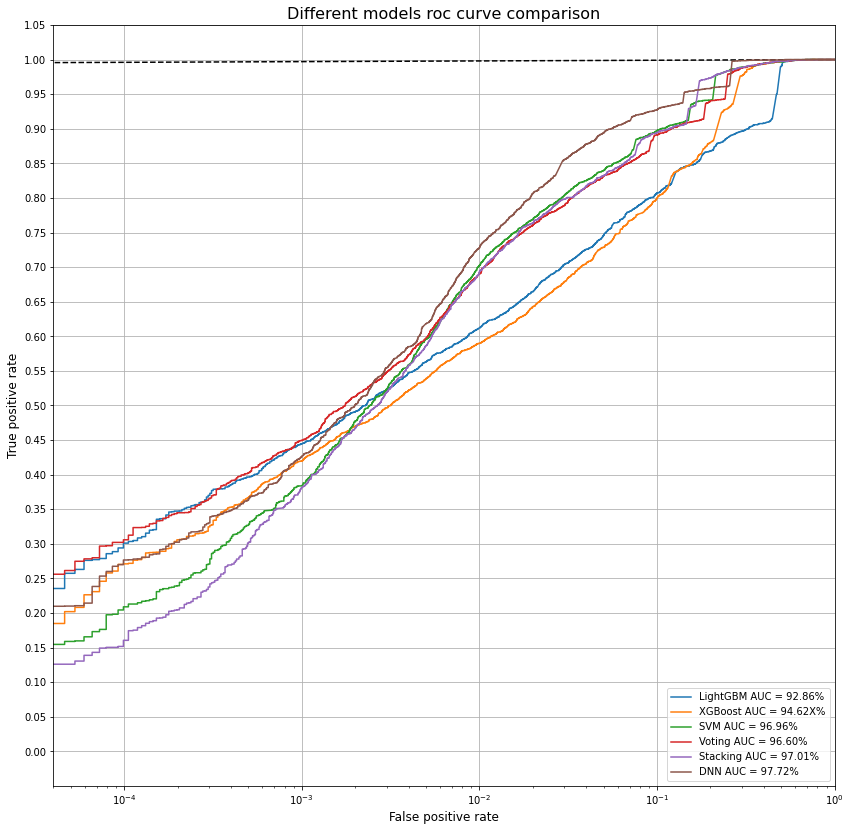

In [ ]:
y_pred_prob1 = modelgbm.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc1 = roc_auc_score(y_test, y_pred_prob1)

y_pred_prob2 = model_b.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
auc2 = roc_auc_score(y_test, y_pred_prob2)


y_pred_prob3 = model_svc.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 =  roc_curve(y_test, y_pred_prob3)
auc3 = roc_auc_score(y_test, y_pred_prob3)

y_pred_prob4 = eclf.predict_proba(X_test)[:,1] 
fpr4 , tpr4, thresholds4 =  roc_curve(y_test, y_pred_prob4)
auc4 = roc_auc_score(y_test, y_pred_prob4)


y_pred_prob5 = clf.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 =  roc_curve(y_test, y_pred_prob5)
auc5 = roc_auc_score(y_test, y_pred_prob5)

y_pred_prob6 = (modeldnn.predict(X_test)).flatten()
fpr6 , tpr6, thresholds6 =  roc_curve(y_test, y_pred_prob6)
auc6 = roc_auc_score(y_test, y_pred_prob6)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= f"LightGBM AUC = {100*auc1 :.2f}%")
plt.plot(fpr2, tpr2, label= f"XGBoost AUC = {100*auc2 :.2f}X%")
plt.plot(fpr3, tpr3, label= f"SVM AUC = {100*auc3 :.2f}%")
plt.plot(fpr4, tpr4, label= f"Voting AUC = {100*auc4 :.2f}%")
plt.plot(fpr5, tpr5, label= f"Stacking AUC = {100*auc5 :.2f}%")
plt.plot(fpr6, tpr6, label= f"DNN AUC = {100*auc6 :.2f}%")
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate",fontsize=16)
plt.title('Different models roc curve comparison',fontsize=18)
plt.legend(loc= 'lower right')
plt.show()

In [ ]:

y_pred_prob1 = modelgbm.predict_proba(X_test_pj)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test_pj, y_pred_prob1)
auc1 = roc_auc_score(y_test_pj, y_pred_prob1)

y_pred_prob2 = model_b.predict_proba(X_test_pj)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test_pj, y_pred_prob2)
auc2 = roc_auc_score(y_test_pj, y_pred_prob2)


y_pred_prob3 = model_svc.predict_proba(X_test_pj)[:,1]
fpr3 , tpr3, thresholds3 =  roc_curve(y_test_pj, y_pred_prob3)
auc3 = roc_auc_score(y_test_pj, y_pred_prob3)

y_pred_prob4 = eclf.predict_proba(X_test_pj)[:,1] 
fpr4 , tpr4, thresholds4 =  roc_curve(y_test_pj, y_pred_prob4)
auc4 = roc_auc_score(y_test_pj, y_pred_prob4)


y_pred_prob5 = clf.predict_proba(X_test_pj)[:,1]
fpr5 , tpr5, thresholds5 =  roc_curve(y_test_pj, y_pred_prob5)
auc5 = roc_auc_score(y_test_pj, y_pred_prob5)

y_pred_prob6 = (modeldnn.predict(X_test_pj)).flatten()
fpr6 , tpr6, thresholds6 =  roc_curve(y_test_pj, y_pred_prob6)
auc6 = roc_auc_score(y_test_pj, y_pred_prob6)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(14) # set height
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= f"LightGBM AUC = {100*auc1 :.2f}%")
plt.plot(fpr2, tpr2, label= f"XGBoost AUC = {100*auc2 :.2f}X%")
plt.plot(fpr3, tpr3, label= f"SVM AUC = {100*auc3 :.2f}%")
plt.plot(fpr4, tpr4, label= f"Voting AUC = {100*auc4 :.2f}%")
plt.plot(fpr5, tpr5, label= f"Stacking AUC = {100*auc5 :.2f}%")
plt.plot(fpr6, tpr6, label= f"DNN AUC = {100*auc6 :.2f}%")
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=12)
plt.ylabel("True positive rate",fontsize=12)
plt.title('Different models roc curve comparison on PJ',fontsize=16)
plt.legend(loc= 'lower right')
plt.show()

# Building a classifier for classifying the predator / victim inside the conversation

We feed one document per author per conversation. This means if an author partook in multiple conversations we will have multiple documents for that author. The benefit of this is this would better reflect the type of data in real-world and have more labeled data for training purposes

In [ ]:

def get_susp_conv_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_predators_dict(file): 
    all_predators = {}
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_predators[row[0]] = 1
    return all_predators
            

def get_features_labels(root, labels_dict, all_predators):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        # only get suspicious conversations
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {}
        for message in conversation:
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(0)
    return corpus, labels

In [ ]:
train_data_path = "data/pan12-sexual-predator-identification-training-corpus-2012-05-01/"
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_path + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

pred_train_file_path = 'data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
pred_test_file_path = 'data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
train_corpus, train_labels = get_features_labels(train_root, get_susp_conv_dict(train_data_path), get_predators_dict(pred_train_file_path))
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path))

## Applying TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
# vectorizer = TfidfVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))
print("Training label shape: {}".format(y_train.shape))
print("Testing label shape: {}".format(y_test.shape))

## SVM

In [ ]:
model = LinearSVC(random_state=0, tol=0.001, loss='squared_hinge')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

## LightGBM

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

## XGBOOST

In [ ]:
import xgboost as xgb
model_b = xgb.XGBClassifier( eval_metric='logloss',use_label_encoder=False)
model_b.fit(X_train, y_train)
pred_y = model_b.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

## Try PJ dataset as test set on trained corpus

In [ ]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    pred_name = file.split('.xml')[0].lower()
    corpus_pj.append(" ".join(df[df['USERNAME'].str.contains(pred_name,case=False)].BODY.tolist()))
    labels_pj.append(1)
    corpus_pj.append(" ".join(df[~df['USERNAME'].str.contains(pred_name,case=False)].BODY.tolist()))
    labels_pj.append(0)

In [ ]:
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
y_test_pj = np.array(labels_pj)

In [ ]:
pred_y = model.predict(X_test_pj)
print(metrics.accuracy_score(y_test_pj, pred_y))
np.unique(pred_y,return_counts=True)

# Classifying using Transformers

## finetune API for text classification
built upon TensorFlow & Keras

In [ ]:
%%capture
import finetune as ft

In [ ]:
from finetune.base_models import BERT, BERTLarge, DistilBERT,RoBERTa,TextCNN

In [ ]:
model = ft.Classifier(base_model=TextCNN,chunk_long_sequences=True, n_epochs=3) # chunk_long_sequences flag moves a sliding window of length max_length across the input, and takes the mean of the feature representations from the windows

Downloading: encoder.json


100%|██████████| 1.04M/1.04M [00:00<00:00, 3.76MiB/s]


Downloading: vocab.bpe


100%|██████████| 456k/456k [00:00<00:00, 2.02MiB/s]


Downloading: model-sm.jl


100%|██████████| 655M/655M [00:28<00:00, 22.7MiB/s]


In [ ]:
model.fit(train_corpus, train_labels)
pred_y = model.predict(test_corpus)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(test_labels, pred_y)*100)
# running time of 2 minutes 

Epoch 3/3: 100%|██████████| 1808/1808 [00:14<00:00, 125.49it/s]
Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 5608it [00:49, 113.30it/s]

Accuracy on PAN12 test dataset:  87.99928673323824


In [ ]:
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(test_labels, pred_y)*100)

Accuracy on PAN12 test dataset:  87.99928673323824


In [ ]:
pred_y = model.predict(corpus_pj)

Inference: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/finetune/base_models/textcnn/featurizer.py:77: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  kernel_initializer=tf.compat.v1.initializers.glorot_normal,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
Inference: 115it [00:23,  4.85it/s]


In [ ]:
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj, pred_y)*100)

Accuracy on PJ test dataset:  96.42857142857143


In [ ]:
model.save(path ='TextCNN_pred_vict_classifier')

# ReShuffeling the train-test pan12 data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df= pd.DataFrame(columns = ['chat','labels'])

In [ ]:
df['chat'] =  train_corpus+test_corpus
df['labels'] = train_labels+test_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['chat'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42)

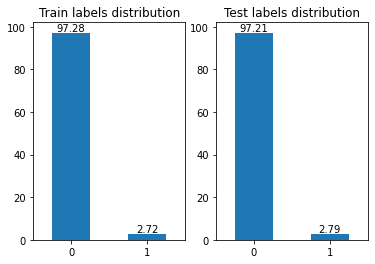

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax = (pd.Series(y_train).value_counts()/len(y_train)*100).round(2).plot(kind='bar',title='Train labels distribution',ax= ax1)
ax.bar_label(ax1.containers[0])
ax = (pd.Series(y_test).value_counts()/len(y_test)*100).round(2).plot(kind='bar',title='Test labels distribution',ax=ax2)
ax.bar_label(ax2.containers[0])
ax1.tick_params(axis='x', rotation=0)
ax2.tick_params(axis='x', rotation=0)
plt.show()

## TF-IDF on data
We will now represent all conversations using BOW with TF-IDF weighting scheme.

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(y_train)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(y_test)

## Create PJ dataset as test set on trained corpus

In [ ]:
from os import listdir
from os.path import isfile, join
import warnings
mypath = 'GeneralData'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove('chatlog.dtd')


In [ ]:
corpus_pj = [] # each row is a string formed from all messages in a conversations
labels_pj = [] # each row is 0 or 1, corresponds to label for same row in corpus
for file in onlyfiles:
    df= pd.read_xml(f'GeneralData/{file}').drop(columns=['COMMENT'])
    df=df[~df['BODY'].isna()]
    df=df[~df['USERNAME'].isna()]
    string = " "
    for text in df.BODY.tolist():
        if text is not None:
            #preprocess:
            #preprocess:
            # text = preprocess_text(text)
            string = string + "\r\n" + text 
    corpus_pj.append(string)
    labels_pj.append(1)

In [ ]:
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)#[:,best_feat]
y_test_pj = np.array(labels_pj)

##LightGBM model classification

In [ ]:
import lightgbm as lgb
modelgbm = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
modelgbm.fit(X_train, y_train)
pred_y = modelgbm.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))
# try on PJ dataset:
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = modelgbm.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

0.9857794853282451
Accuracy on PAN12 test dataset:  98.57794853282451
Accuracy on PJ test dataset:  98.21428571428571


(array([0, 1]), array([ 1, 55]))

## XGBoost model classification

In [ ]:
import xgboost as xgb
np.random.seed(12)
model_b = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)
model_b.fit(X_train, y_train)
pred_y = model_b.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
# try on PJ dataset:
pred_y = model_b.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.53681514411046
Accuracy on PJ test dataset:  94.64285714285714


(array([0, 1]), array([ 3, 53]))

try with best features to achieve higher accuracy on test sets

In [ ]:
best_feat = pd.Series(model_b.feature_importances_).sort_values(ascending=False).nlargest(155).index.tolist()
model_best_feat = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False)
model_best_feat.fit(X_train[:,best_feat], y_train)
pred_y = model_best_feat.predict(X_test[:,best_feat])
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
#transform it with TF-IDF based on the trained corpus
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj[:,best_feat]
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_best_feat.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.53681514411046
Accuracy on PJ test dataset:  94.64285714285714


(array([0, 1]), array([ 3, 53]))

## Applying SVM 

Linear support

In [ ]:
#SVM
model_linear = LinearSVC(random_state=0, C=2.9, loss='squared_hinge', dual=True)
model_linear.fit(X_train, y_train)
pred_y = model_linear.predict(X_test)
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)
X_test_pj = vectorizer.transform(corpus_pj)
X_test_pj = scipy.sparse.csr_matrix(X_test_pj)
X_test_pj =X_test_pj
y_test_pj = np.array(labels_pj)
# try on PJ dataset:
pred_y = model_linear.predict(X_test_pj)
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(y_test_pj, pred_y)*100)
np.unique(pred_y,return_counts=True)

Accuracy on PAN12 test dataset:  98.96370006182471
Accuracy on PJ test dataset:  96.42857142857143


(array([0, 1]), array([ 2, 54]))

## Applying DeepNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import random as python_random
import tensorflow as tf

In [ ]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['chat'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
# PAN12 data
X_train = vectorizer.fit_transform(X_train).astype('float16')
X_test = vectorizer.transform(X_test).astype('float16')
y_train = np.array(y_train)
y_test = np.array(y_test)
##pj -data 
X_test_pj = vectorizer.transform(corpus_pj).astype('float16')
y_test_pj = np.array(labels_pj)

In [ ]:
# Model Training 
print ("Create model ... ")
def build_model(dim_inp):
    K.clear_session()
    np.random.seed(12)
    python_random.seed(12)
    tf.random.set_seed(12)
    model = Sequential()
    model.add(Dense(256, input_dim=dim_inp, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

print("Compile model ...")
model = build_model(X_train.shape[1])

In [ ]:
# Train model
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, shuffle="batch",
                epochs=3)


In [ ]:
pred_y = model.predict(X_test)
pred_y =np.round(pred_y.flatten())
print('Accuracy on PAN12 test dataset: ',metrics.accuracy_score(y_test, pred_y)*100)

In [ ]:
pred_y = model.predict(X_test_pj)
pred_y =np.round(pred_y.flatten())
print('Accuracy on PJ test dataset: ',metrics.accuracy_score(labels_pj,pred_y)*100)

# Try NLP tactics: tokenize, lemmatize, and then preprocess

In [ ]:
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk import regexp_tokenize as rxtoken
from nltk.stem import SnowballStemmer, RegexpStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

In [ ]:
def tokenization(text):
    #token = word_tokenize(text) # Separa el texto en tokens
    token = regexp_tokenize(text,'[^0-9]') # Extrae los token del texto sin numeros
    token = ''.join(str(k) for k in token) # Une los items de la lista
    return token.split() # Devuelve tokens del texto

def lemmatization(text):
    stemmer = SnowballStemmer('english') # Clase Stemming
    stem_text = []
    for word in text: # Recorro cada palabra en la lista y extraigo su raiz
        stem_text.append(stemmer.stem(word))
    return stem_text # Devuelvo la raiz de cada palabra
  
def preprocessText(text):
    stopwd = stopwords.words('english') # Conjunto de stopwords
    tokens = tokenization(text) # Obtengo el token del texto
    if tokens:
        # Si el token no pertenece al conjunto de stopwords lo agrego a la lista
        text_without_stopwd = [word for word in tokens if len(word) > 2 and word not in stopwd]
        text_process = lemmatization(text_without_stopwd) # Obtengo la base de cada palabra en la lista
        if text_process:
            return text_process # Devuelvo una lista con las palabras mas significativas
def processText(text):
  token = tokenization(text) # Obtengo el token del texto
  clean_words = [word for word in token if len(word)>2 and word not in stopwords.words('english')]
  lemma_words = lemmatization(clean_words)
  proces_text = [text for text in lemma_words if text]
  proces_text = ' '.join(str(t) for t in proces_text if t)
  return proces_text 